# Micronekton Lower-mesopelagic : LMTL vs SeapoPym (initial conditions)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr
from dask.distributed import Client

from seapopym.configuration.no_transport import (
    ForcingParameter,
    ForcingUnit,
    FunctionalGroupParameter,
    FunctionalGroupUnit,
    FunctionalTypeParameter,
    MigratoryTypeParameter,
    NoTransportConfiguration,
)
from seapopym.configuration.no_transport.environment_parameter import ChunkParameter, EnvironmentParameter
from seapopym.configuration.no_transport.kernel_parameter import KernelParameter
from seapopym.model.no_transport_model import NoTransportLightModel
from seapopym.standard.units import StandardUnitsLabels


In [2]:
client = Client(n_workers=4, threads_per_worker=1, memory_limit="10GB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 37.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52232,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:52245,Total threads: 1
Dashboard: http://127.0.0.1:52248/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:52235,


In [3]:
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams.update({"figure.figsize": (10, 6), "axes.grid": True, "grid.alpha": 0.5, "grid.linestyle": "--"})


Here we explicitly set a chunksize for the forcing data so Dask does not need to scatter the data across workers.


In [4]:
path_forcing = "/Users/adm-lehodey/Documents/Workspace/Data/phd/HOT/CMEMS/cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-i_1718149967802.nc"
path_bio = "/Users/adm-lehodey/Documents/Workspace/Data/phd/HOT/CMEMS/cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i_1718150094521.nc"
chunks = {"latitude": 6, "longitude": 6}

forcing = xr.open_dataset(path_forcing, chunks={})
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
bio = xr.open_dataset(path_bio, chunks={})

In [5]:
display(forcing)


<xarray.Dataset> Size: 63MB
Dimensions:              (time: 9131, depth: 3, latitude: 12, longitude: 12)
Coordinates:
  * depth                (depth) float32 12B 1.0 2.0 3.0
  * latitude             (latitude) float32 48B 22.08 22.17 22.25 ... 22.92 23.0
  * longitude            (longitude) float32 48B -158.5 -158.4 ... -157.7 -157.6
  * time                 (time) datetime64[ns] 73kB 1998-01-01 ... 2022-12-31
Data variables:
    T                    (time, depth, latitude, longitude) float32 16MB dask.array<chunksize=(9131, 3, 12, 12), meta=np.ndarray>
    U                    (time, depth, latitude, longitude) float32 16MB dask.array<chunksize=(9131, 3, 12, 12), meta=np.ndarray>
    V                    (time, depth, latitude, longitude) float32 16MB dask.array<chunksize=(9131, 3, 12, 12), meta=np.ndarray>
    pelagic_layer_depth  (time, depth, latitude, longitude) float32 16MB dask.array<chunksize=(9131, 3, 12, 12), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.11
    title:             Physical forcings of global ocean low and mid trophic ...
    institution:       CLS
    source:            SEAPODYM-LMTL 3.0.0
    history:           Created on 2022-09-28
    references:        http://www.cls.fr; http://www.seapodym.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_MULTIYEAR_BGC_001_033
    subset:datasetId:  cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-i_202211
    subset:date:       2024-06-11T23:52:47.809Z

In [6]:
display(bio)

<xarray.Dataset> Size: 47MB
Dimensions:       (latitude: 12, longitude: 12, time: 9131)
Coordinates:
  * latitude      (latitude) float32 48B 22.08 22.17 22.25 ... 22.83 22.92 23.0
  * longitude     (longitude) float32 48B -158.5 -158.4 -158.3 ... -157.7 -157.6
  * time          (time) datetime64[ns] 73kB 1998-01-01 ... 2022-12-31
Data variables:
    mnkc_epi      (time, latitude, longitude) float32 5MB dask.array<chunksize=(9131, 12, 12), meta=np.ndarray>
    mnkc_hmlmeso  (time, latitude, longitude) float32 5MB dask.array<chunksize=(9131, 12, 12), meta=np.ndarray>
    mnkc_lmeso    (time, latitude, longitude) float32 5MB dask.array<chunksize=(9131, 12, 12), meta=np.ndarray>
    mnkc_mlmeso   (time, latitude, longitude) float32 5MB dask.array<chunksize=(9131, 12, 12), meta=np.ndarray>
    mnkc_mumeso   (time, latitude, longitude) float32 5MB dask.array<chunksize=(9131, 12, 12), meta=np.ndarray>
    mnkc_umeso    (time, latitude, longitude) float32 5MB dask.array<chunksize=(9131, 12, 12), meta=np.ndarray>
    npp           (time, latitude, longitude) float32 5MB dask.array<chunksize=(9131, 12, 12), meta=np.ndarray>
    zeu           (time, latitude, longitude) float32 5MB dask.array<chunksize=(9131, 12, 12), meta=np.ndarray>
    zooc          (time, latitude, longitude) float32 5MB dask.array<chunksize=(9131, 12, 12), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.11
    title:             Global ocean low and mid trophic levels biomass conten...
    institution:       CLS
    source:            SEAPODYM-LMTL 3.0.0
    history:           Created on 2022-09-28
    references:        http://www.cls.fr; http://www.seapodym.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_MULTIYEAR_BGC_001_033
    subset:datasetId:  cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i_202211
    subset:date:       2024-06-11T23:54:54.527Z

## Initialize the model


In [7]:
global_energy_coef = 0.0042
functional_type = FunctionalTypeParameter(
    lambda_temperature_0=(1 / 2109),
    gamma_lambda_temperature=0.125,
    tr_0=527,
    gamma_tr=-0.125,
)
lower_mesopelagic = FunctionalGroupUnit(
    name="lower_mesopelagic",
    migratory_type=MigratoryTypeParameter(day_layer=3, night_layer=3),
    functional_type=functional_type,
    energy_transfert=global_energy_coef * 0.18,
)

f_groups = FunctionalGroupParameter(functional_group=[lower_mesopelagic])
p_param = ForcingParameter(
    temperature=ForcingUnit(forcing=forcing["T"]),
    primary_production=ForcingUnit(forcing=bio["npp"]),
)
configuration = NoTransportConfiguration(
    forcing=p_param,
    functional_group=f_groups,
    kernel=KernelParameter(compute_initial_conditions=True),
    environment=EnvironmentParameter(chunk=ChunkParameter(**chunks)),
)
micronekton_model = NoTransportLightModel.from_configuration(configuration=configuration)
micronekton_model.state

npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.
npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.


<xarray.Dataset> Size: 21MB
Dimensions:                     (time: 9131, depth: 3, latitude: 12,
                                 longitude: 12, functional_group: 1, cohort: 527)
Coordinates:
  * depth                       (depth) float32 12B 1.0 2.0 3.0
  * latitude                    (latitude) float32 48B 22.08 22.17 ... 23.0
  * longitude                   (longitude) float32 48B -158.5 -158.4 ... -157.6
  * time                        (time) datetime64[ns] 73kB 1998-01-01 ... 202...
  * cohort                      (cohort) int64 4kB 0 1 2 3 4 ... 523 524 525 526
  * functional_group            (functional_group) int64 8B 0
Data variables: (12/18)
    temperature                 (time, latitude, longitude, depth) float32 16MB dask.array<chunksize=(9131, 6, 6, 3), meta=np.ndarray>
    primary_production          (time, latitude, longitude) float32 5MB dask.array<chunksize=(9131, 6, 6), meta=np.ndarray>
    name                        (functional_group) <U17 68B dask.array<chunksize=(1,), meta=np.ndarray>
    energy_transfert            (functional_group) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    lambda_temperature_0        (functional_group) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    gamma_lambda_temperature    (functional_group) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                          ...
    max_timestep                (functional_group, cohort) float64 4kB dask.array<chunksize=(1, 527), meta=np.ndarray>
    mean_timestep               (functional_group, cohort) float64 4kB dask.array<chunksize=(1, 527), meta=np.ndarray>
    timestep                    float64 8B 1.0
    angle_horizon_sun           float64 8B 0.0
    compute_initial_conditions  bool 1B True
    compute_preproduction       bool 1B False

In [ ]:
micronekton_model.run()

In [ ]:
micronekton_model.state

In [10]:
biomass_results = micronekton_model.state.biomass
initial_conditions = micronekton_model.export_initial_conditions().drop_vars("time")


In [11]:
# Prediction
biomass_results = biomass_results.pint.quantify().pint.to("g/m2").mean(["latitude", "longitude", "functional_group"])
# Seapodym LMTL
lmtl_mnk = bio[["mnkc_lmeso"]]
lmtl_mnk = lmtl_mnk.pint.quantify().pint.to("g/m2")
wet_to_carbon = 1 / 11.9
lmtl_mnk = lmtl_mnk * wet_to_carbon
lmtl_mnk = lmtl_mnk.mean(("latitude", "longitude"))

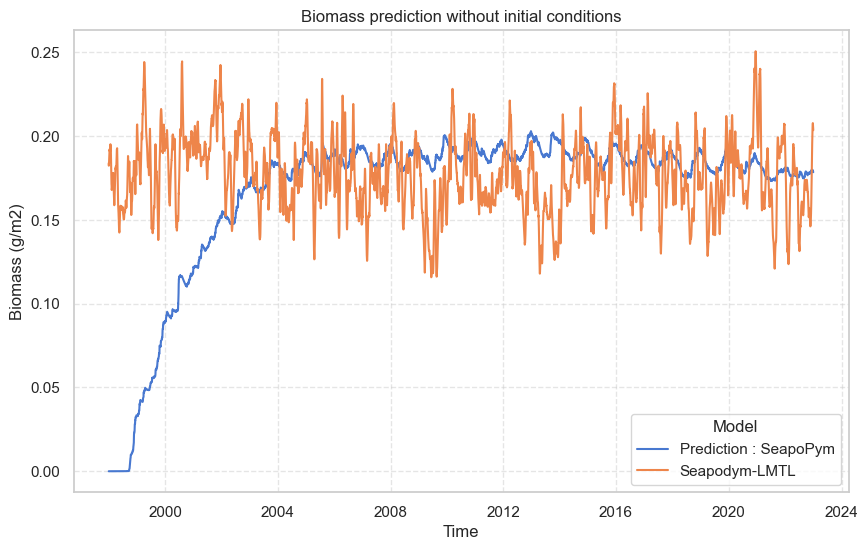

In [12]:
plot_without_init = pd.DataFrame(
    {
        "Prediction : SeapoPym": biomass_results.rename("Prediction : SeapoPym").pint.dequantify().to_series(),
        "Seapodym-LMTL": lmtl_mnk["mnkc_lmeso"].pint.dequantify().to_series(),
    }
)

plot_without_init = plot_without_init.reset_index().melt(id_vars="time", var_name="Model", value_name="Biomass (g/m2)")

plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_without_init, x="time", y="Biomass (g/m2)", hue="Model")
plt.title("Biomass prediction without initial conditions")
plt.xlabel("Time")
plt.ylabel("Biomass (g/m2)")
plt.legend(title="Model")
plt.show()


---

## Let's try with initial conditions


In [13]:
p_param = ForcingParameter(
    temperature=ForcingUnit(forcing=forcing["T"]),
    primary_production=ForcingUnit(forcing=bio["npp"]),
    initial_condition_biomass=ForcingUnit(forcing=initial_conditions["biomass"]),
    initial_condition_production=ForcingUnit(forcing=initial_conditions["preproduction"]),
)

configuration = NoTransportConfiguration(
    functional_group=f_groups, forcing=p_param, environment=EnvironmentParameter(chunk=ChunkParameter(**chunks))
)
micronekton_model_with_initial_conditions = NoTransportLightModel.from_configuration(configuration=configuration)

npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.
npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.


In [14]:
micronekton_model_with_initial_conditions.run()

In [15]:
# Prediction
biomass_results = micronekton_model_with_initial_conditions.state.biomass
biomass_results = biomass_results.pint.quantify().pint.to("g/m2").mean(["latitude", "longitude", "functional_group"])
# Seapodym LMTL
lmtl_mnk = bio[["mnkc_lmeso"]]
lmtl_mnk = lmtl_mnk.pint.quantify().pint.to("g/m2")
wet_to_carbon = 1 / 11.9
lmtl_mnk = lmtl_mnk * wet_to_carbon
lmtl_mnk = lmtl_mnk.mean(("latitude", "longitude"))

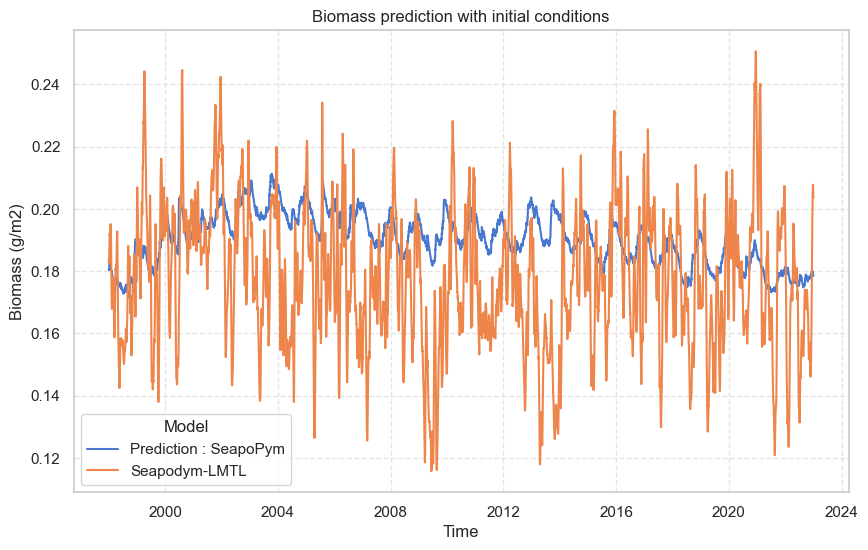

In [16]:
plot_with_init = pd.DataFrame(
    {
        "Prediction : SeapoPym": biomass_results.rename("Prediction : SeapoPym").pint.dequantify().to_series(),
        "Seapodym-LMTL": lmtl_mnk["mnkc_lmeso"].pint.dequantify().to_series(),
    }
)

plot_with_init = plot_with_init.reset_index().melt(id_vars="time", var_name="Model", value_name="Biomass (g/m2)")
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_with_init, x="time", y="Biomass (g/m2)", hue="Model")
plt.title("Biomass prediction with initial conditions")
plt.xlabel("Time")
plt.ylabel("Biomass (g/m2)")
plt.legend(title="Model")
plt.show()
